In [17]:
library(forecast)
library(lattice)
#library(ncdf4)
library(ggplot2)
library(RColorBrewer)
library(ggmap)

In [18]:
fuzzify<-function(x)
{
  idx = (x == 0)
    if(sum(idx) != 0){
  y <- array(0.0 ,length(x))
  y[idx] <- x[idx] + 0.005*runif(1,min=0.0, max=1.0) 
  y[!idx]<-x[!idx] + 0.005*runif(1,min=-1.0, max=1.0)
    return(y)
}
 return(x) 
}

phase_average<-function(x, freq)
{    
  N = length(x)
  result = numeric(N)
  averages = numeric(freq)
  stds = numeric(freq)    
  for (j in 1:freq){
        Idx = seq(j,N,12)
        averages[j] = mean(x[Idx])
        stds[j] = sd(x[Idx])
      if(stds[j] == 0){
          result[Idx] =  0
      }else{
        result[Idx] = (x[Idx] - averages[j])/stds[j]
          }
      
      }
    returnList <- list("result" = result, "averages" = averages, "stds" = stds)
    return(returnList)  
}

inv_phase_average<-function(x, freq, avg, std)
{    
  N = length(x)
  result = numeric(N)  
  for (j in 1:freq){
        Idx = seq(j,N,freq)
        result[Idx] = x[Idx]* std[j] + avg[j]      
      }
    return(result)  
}

inBoxCox<-function(x, lambda){
 if(lambda == 0){
    inv_x = exp(x)
    } else{
     inx_x = (x*lambda + 1) ^ (1/lambda)
 }
    return(inx_x)
}

In [19]:
checkresiduals1 <- function(object, lag, df=NULL, test, plot=TRUE, ...) {
  showtest <- TRUE
  if (missing(test)) {
    if (is.element("lm", class(object))) {
      test <- "BG"
    } else {
      test <- "LB"
    }
    showtest <- TRUE
  }
  else if (test != FALSE) {
    test <- match.arg(test, c("LB", "BG"))
    showtest <- TRUE
  }
  else {
    showtest <- FALSE
  }
  
  # Extract residuals
  if (is.element("ts", class(object)) | is.element("numeric", class(object))) {
    residuals <- object
    object <- list(method = "Missing")
  }
  else {
    residuals <- residuals(object)
  }

  if (length(residuals) == 0L) {
    stop("No residuals found")
  }
  
  if ("ar" %in% class(object)) {
    method <- paste("AR(", object$order, ")", sep = "")
  } else if (!is.null(object$method)) {
    method <- object$method
  } else if ("HoltWinters" %in% class(object)) {
    method <- "HoltWinters"
  } else if ("StructTS" %in% class(object)) {
    method <- "StructTS"
  } else {
    method <- try(as.character(object), silent = TRUE)
    if ("try-error" %in% class(method)) {
      method <- "Missing"
    } else if (length(method) > 1 | base::nchar(method[1]) > 50) {
      method <- "Missing"
    }
  }
  if (method == "Missing") {
    main <- "Residuals"
  } else {
    main <- paste("Residuals from", method)
  }

  if (plot) {
    suppressWarnings(ggtsdisplay(residuals, plot.type = "histogram", main = main, ...))
  }

  # Check if we have the model
  if (is.element("forecast", class(object))) {
    object <- object$model
  }

  if (is.null(object) | !showtest) {
    return(invisible())
  }

  # Seasonality of data
  freq <- frequency(residuals)

  # Find model df
  if(grepl("STL \\+ ", method)){
    warning("The fitted degrees of freedom is based on the model used for the seasonally adjusted data.")
  }
  df <- modeldf(object)
  
  if (missing(lag)) {
    lag <- ifelse(freq > 1, 2 * freq, 10)
    lag <- min(lag, round(length(residuals)/5))
    lag <- max(df+3, lag)
  }

  if (!is.null(df)) {
    if (test == "BG") {
      # Do Breusch-Godfrey test
      BGtest <- lmtest::bgtest(object, order = lag)
      BGtest$data.name <- main
      #print(BGtest)
      return(BGtest)
    }
    else {
      # Do Ljung-Box test
      LBtest <- Box.test(zoo::na.approx(residuals), fitdf = df, lag = lag, type = "Ljung")
      LBtest$method <- "Ljung-Box test"
      LBtest$data.name <- main
      names(LBtest$statistic) <- "Q*"
      #print(LBtest)
      #cat(paste("Model df: ", df, ".   Total lags used: ", lag, "\n\n", sep = ""))
      return(LBtest)
    }
  }
}

modeldf <- function(object, ...){
  UseMethod("modeldf")
}

modeldf.default <- function(object, ...){
  warning("Could not find appropriate degrees of freedom for this model.")
  NULL
}

modeldf.ets <- function(object, ...){
  length(object$par)
}

modeldf.Arima <- function(object, ...){
  length(object$coef)
}

modeldf.bats <- function(object, ...){
  length(object$parameters$vect) + NROW(object$seed.states)
}

modeldf.lm <- function(object, ...){
  length(object$coefficients)
}

modeldf.lagwalk <- function(object, ...){
  as.numeric(object$par$includedrift)
}

modeldf.meanf <- function(object, ...){
  1
}

In [20]:
ploter<-function(filename, title){
    fileinfo =  paste("./results/",filename,sep="")
    load(fileinfo)

    rotate <- function(x) t(apply(x, 2, rev))
    P<-rotate(P)



    #levelplot(P)

    #install.packages("ggmap")
    #library(ggmap)
    #ggmap(get_map(location=c(-100,49),source="stamen",zoom=8))



    load("lat.RData")
    load("lon.RData")
    i = lon > 180
    lon [i] = lon[i] - 360
    lat = rev(lat)

    df<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
    names(df)<-c("longitude","latitude","P")

    for(i in c(1:34)){
      for(j in c(1:32)){
        if (!is.na(P[i,j])){
            de<-data.frame(lon[i],lat[j],P[i,j])
            names(de)<-c("longitude","latitude","P")
            df <- rbind(df,de)        
        }
       }
    }


    #africa <- c(left = -24, bottom = -40, right = 60, top = 40)
    #map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

    #ggmap(map)+geom_point(data = df,aes(x=longitude,y=latitude,size=P))

    P1 = matrix( rep( 0, c*r ), nrow = c)

    P1[P<0.05] = 0.05

    P1[P>=0.05] = NA

    P1[is.na(P)] = NA

    df1<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
    names(df1)<-c("longitude","latitude","P")

    for(i in c(1:34)){
      for(j in c(1:32)){
        if (!is.na(P1[i,j])){
            de1<-data.frame(lon[i],lat[j],P1[i,j])
            names(de1)<-c("longitude","latitude","P")
            df1 <- rbind(df1,de1)        
        }
       }
    }


    africa <- c(left = -24, bottom = -40, right = 60, top = 40)
    map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

    ggmap(map)+geom_point(data = df1,aes(x=longitude,y=latitude,size=P))+ggtitle(title)
}

In [21]:
load("data.RData")
load("lat.RData")
load("lon.RData")

In [22]:
n_train = 20
# Set forecasting window length (in years)
n_test = 3
# Set start year
start_year = 1946
origin = 1992
# Set annual sampling rate
f = 12
h = n_test * f

skill <- list()

length.lon = dim(data)[1]
length.lat = dim(data)[2]
L = dim(data)[3]

In [23]:
r = length(lat)
c = length(lon)

In [24]:
#df<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric, as.numeric)
#names(df.A)<-c("i","j","lon","lat","P_value")
P = matrix( rep( 0, c*r ), nrow = r)

In [17]:
for(i in c(1:r)){
  for(j in c(1:c)){
    if (is.na(data[j,i,L])){
        #print(i)
        #print(j)
        P[i,j] <- NA
    }else{
        x <- data[j,i,]
        x <- sapply(x, fuzzify)

        index = (origin - (start_year - 1)) * 12 +1

        x.ts <- x[index:length(x)-1]

        train_start = index
        train_end = train_start+n_train*f-1

        #test_start = train_end + 1
        #test_end = test_start + n_test*f -1

        x.train <- x[train_start:train_end]
        #x.test <- x[test_start:test_end]

        x.train <- ts(x.train, start = c(origin, 1), freq=f)
        #x.test <- ts(x.test, start = c(origin+n_train, 1), freq=f)
        
        #lambda <- BoxCox.lambda(x.train)

        pa = phase_average(x.train, f)
        x.train.t <- ts(pa$result, start = c(origin, 1), freq=f)
        
        E = ets(x.train.t)
        
        
        P[i,j] = checkresiduals1(E, plot = F)$p.value        
  }      
 }     
}

In [19]:
save(P, file="PE.Rdata")

In [96]:
load("PE.Rdata")

In [25]:
load("./results/PAWithNoSeasonADJ.Rdata")

In [51]:
load("./results/PAall.Rdata")

In [52]:
rotate <- function(x) t(apply(x, 2, rev))
P<-rotate(P)



#levelplot(P)

In [53]:
#install.packages("ggmap")
#library(ggmap)
#ggmap(get_map(location=c(-100,49),source="stamen",zoom=8))

In [54]:
load("lat.RData")
load("lon.RData")
i = lon > 180
lon [i] = lon[i] - 360
lat = rev(lat)

In [55]:
df<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
names(df)<-c("longitude","latitude","P")

In [56]:
for(i in c(1:34)){
  for(j in c(1:32)){
    if (!is.na(P[i,j])){
        de<-data.frame(lon[i],lat[j],P[i,j])
        names(de)<-c("longitude","latitude","P")
        df <- rbind(df,de)        
    }
   }
}


In [57]:
africa <- c(left = -24, bottom = -40, right = 60, top = 40)
map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

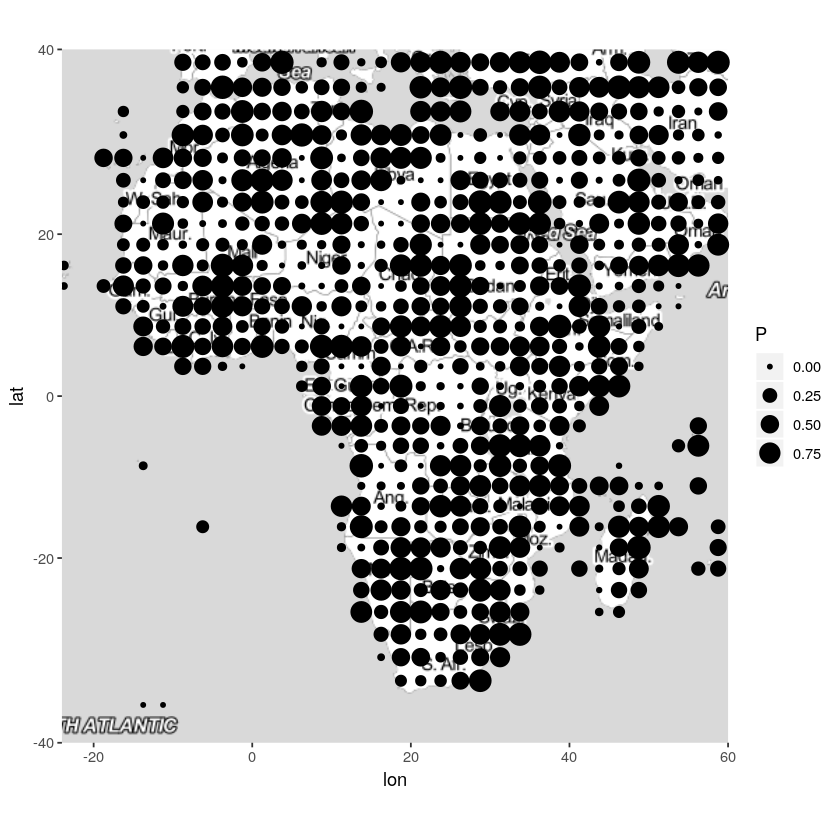

In [58]:
ggmap(map)+geom_point(data = df,aes(x=longitude,y=latitude,size=P))

In [59]:
P1 = matrix( rep( 0, c*r ), nrow = c)

In [60]:
P1[P<0.05] = 0.05

In [61]:
P1[P>=0.05] = NA

In [62]:
P1[is.na(P)] = NA

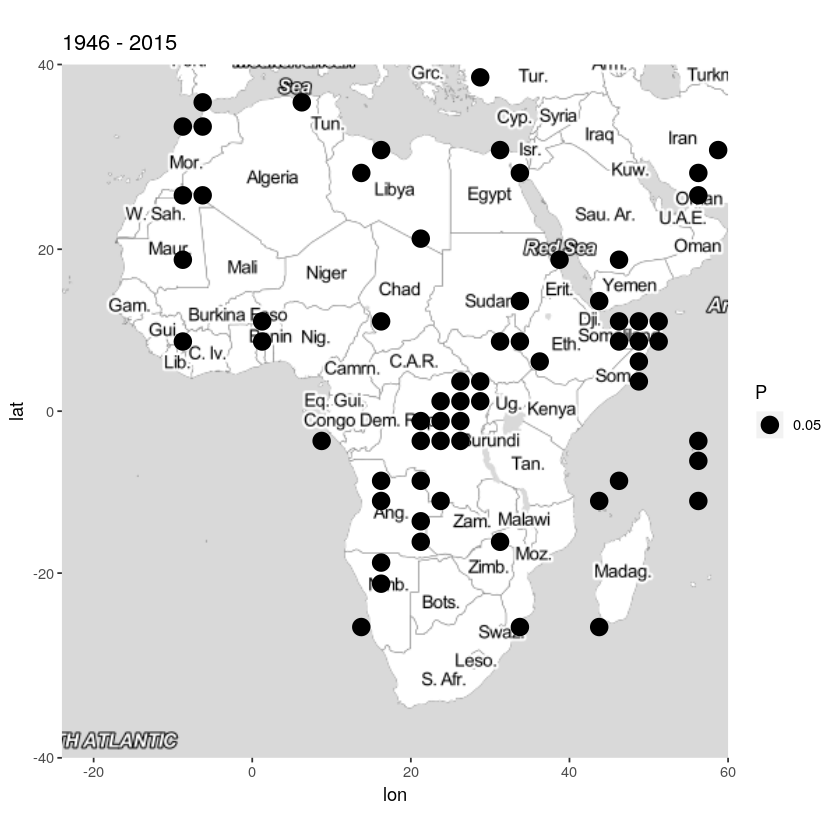

In [67]:
df1<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
names(df1)<-c("longitude","latitude","P")

for(i in c(1:34)){
  for(j in c(1:32)){
    if (!is.na(P1[i,j])){
        de1<-data.frame(lon[i],lat[j],P1[i,j])
        names(de1)<-c("longitude","latitude","P")
        df1 <- rbind(df1,de1)        
    }
   }
}


africa <- c(left = -24, bottom = -40, right = 60, top = 40)
map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

ggmap(map)+geom_point(data = df1,aes(x=longitude,y=latitude,size=P))+ggtitle("1946 - 2015")

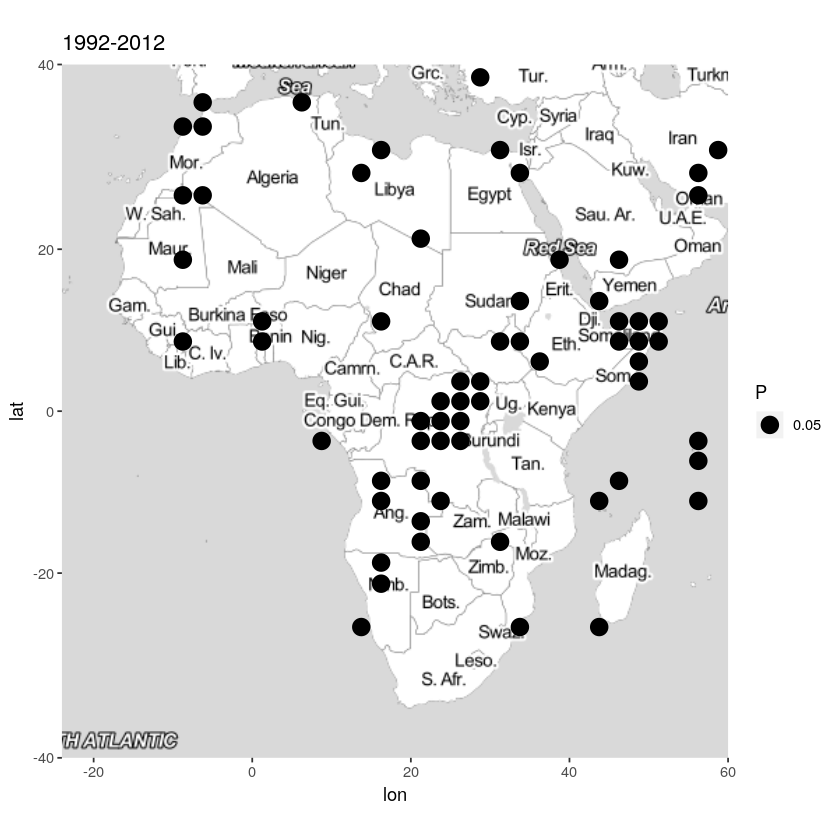

In [88]:
ploter("PA.Rdata", "1992-2012")

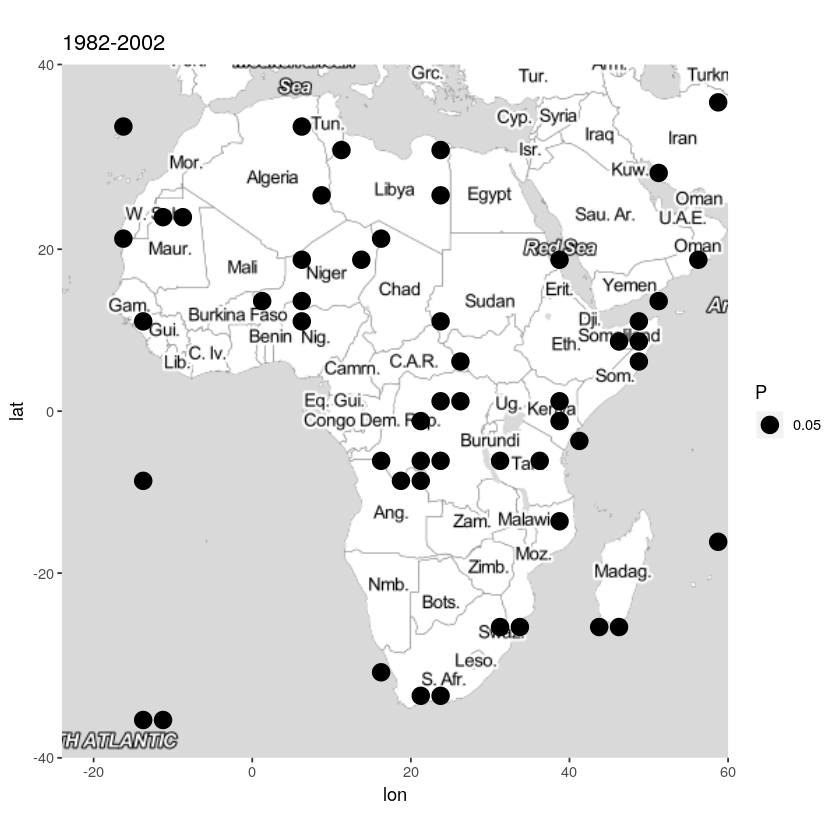

In [89]:
ploter("PA1.Rdata","1982-2002")

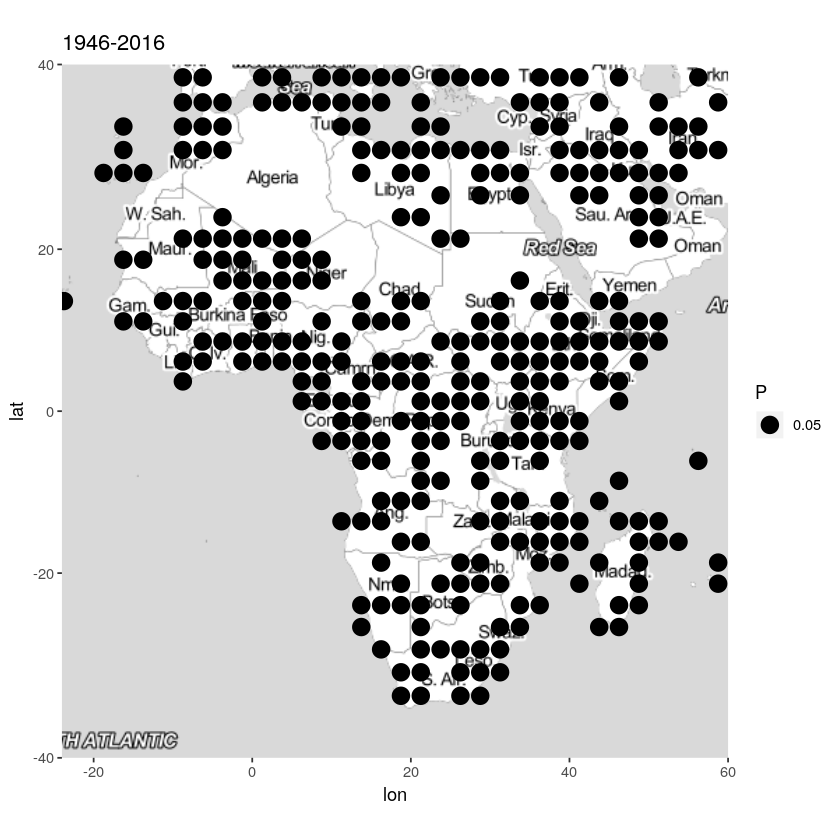

In [90]:
ploter("PAWithNoSeasonADJ.Rdata","1946-2016")

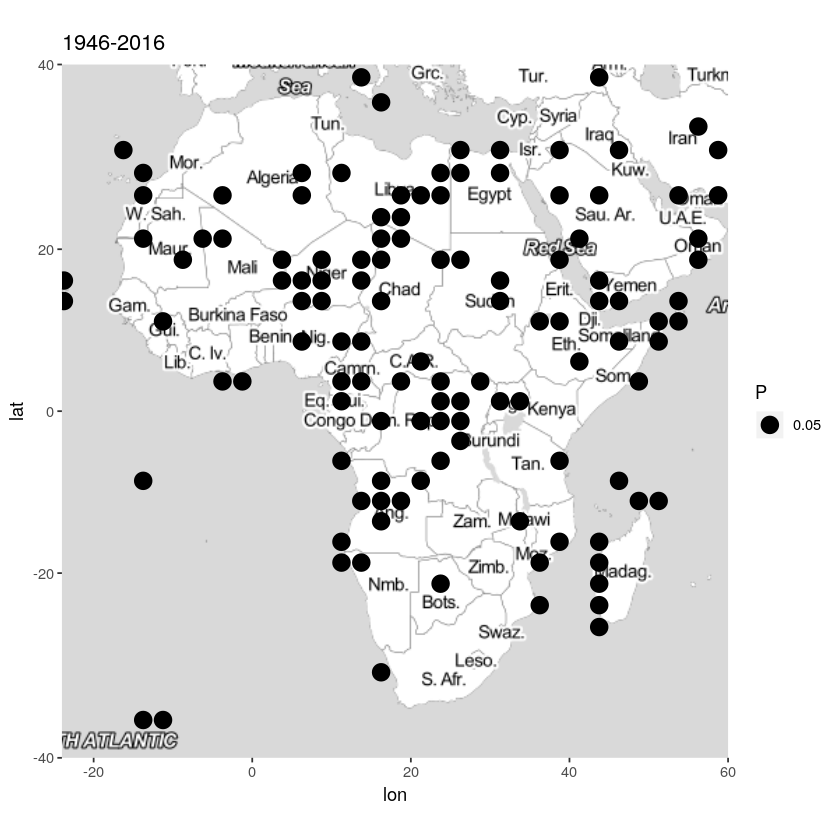

In [91]:
ploter("PAall.Rdata","1946-2016")

In [91]:
#YlOrBr <- c("#FFFFD4", "#FED98E", "#FE9929", "#D95F0E", "#993404")

#ggmap(map) +
#stat_density2d(data = df, aes(x=longitude, y=latitude, fill = ..level.., alpha = ..level..),
#               geom = "polygon", size = 0.005, bins = 20) +
#scale_fill_gradient(low = "red", high = "green") +
#scale_alpha(range = c(0, 0.3), guide = FALSE)

In [16]:
load("./results/PA1.Rdata")

In [12]:
rotate <- function(x) t(apply(x, 2, rev))

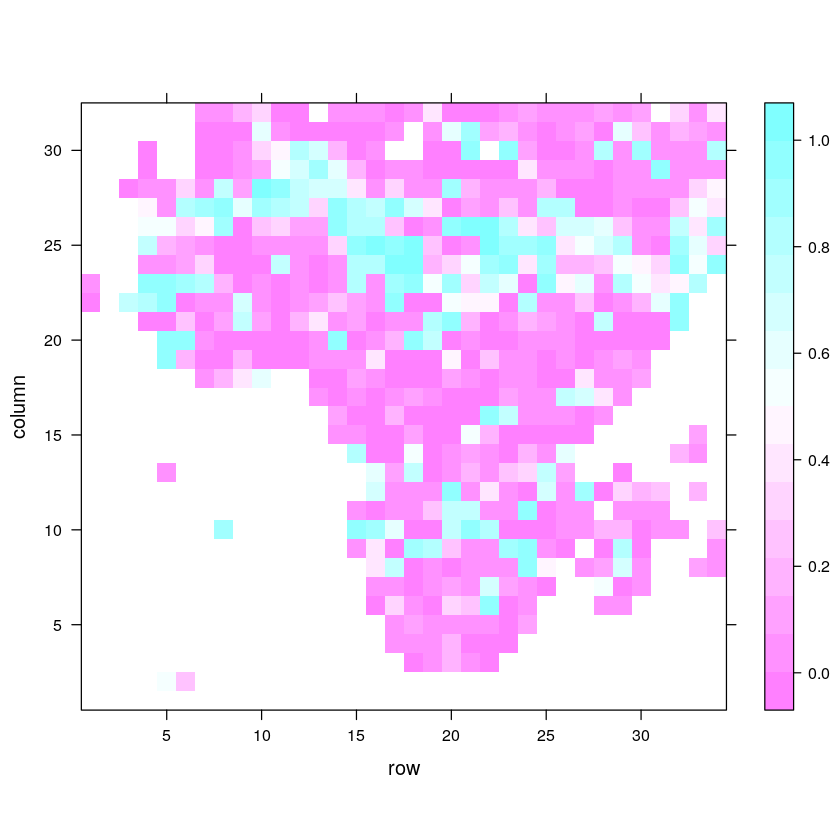

In [13]:

P<-rotate(P)



levelplot(P)

In [14]:
load("lat.RData")
load("lon.RData")
i = lon > 180
lon [i] = lon[i] - 360
lat = rev(lat)

In [15]:
df<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
names(df.E)<-c("longitude","latitude","P")

for(i in c(1:34)){
  for(j in c(1:32)){
    if (!is.na(P[i,j])){
        de<-data.frame(lon[i],lat[j],P[i,j])
        names(de)<-c("longitude","latitude","P")
        df <- rbind(df,de)        
    }
   }
}

In [16]:
africa <- c(left = -24, bottom = -40, right = 60, top = 40)
map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

ERROR: Error in get_stamenmap(africa, zoom = 3, maptype = "toner-lite"): could not find function "get_stamenmap"


In [29]:
africa <- c(left = -24, bottom = -40, right = 60, top = 40)
map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

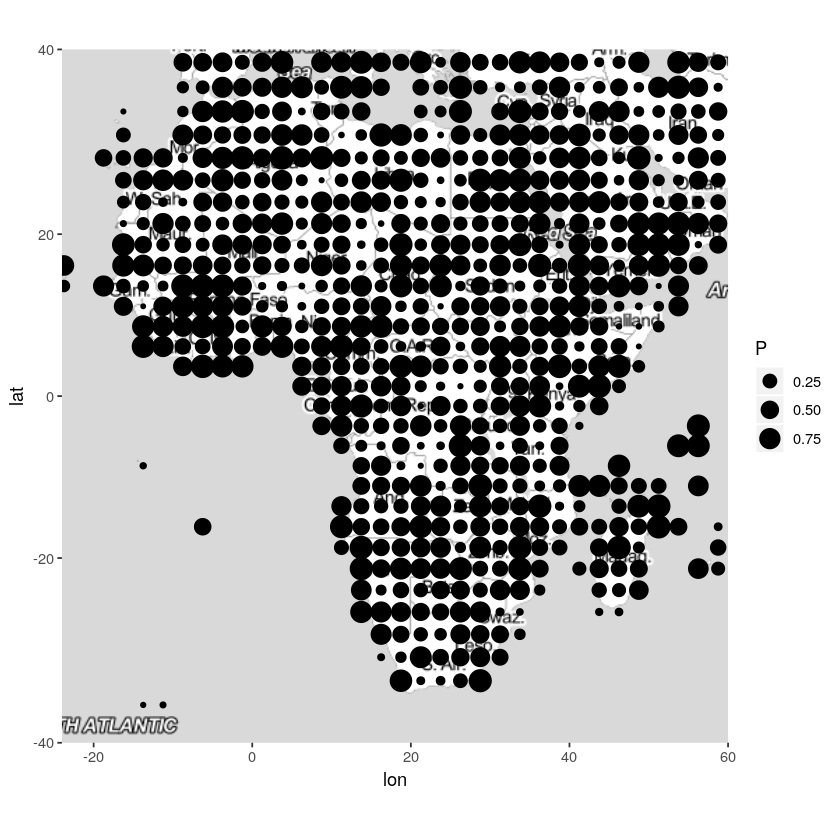

In [30]:
ggmap(map)+geom_point(data = df,aes(x=longitude,y=latitude,size=P))

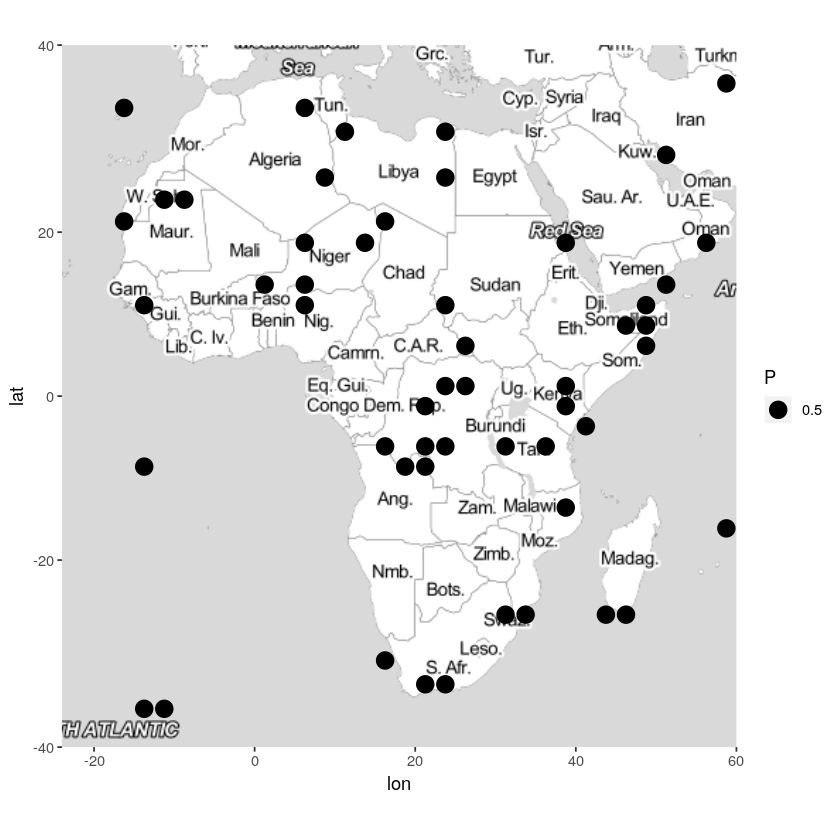

In [34]:
P1 = matrix( rep( 0, c*r ), nrow = c)

P1[P<0.05] = 0.5

P1[P>=0.05] = NA

P1[is.na(P)] = NA

df1<-data.frame(as.numeric,as.numeric,as.numeric, as.numeric)
names(df1)<-c("longitude","latitude","P")

for(i in c(1:34)){
  for(j in c(1:32)){
    if (!is.na(P1[i,j])){
        de1<-data.frame(lon[i],lat[j],P1[i,j])
        names(de1)<-c("longitude","latitude","P")
        df1 <- rbind(df1,de1)        
    }
   }
}


africa <- c(left = -24, bottom = -40, right = 60, top = 40)
map = get_stamenmap(africa, zoom = 3,maptype = "toner-lite") #%>% ggmap()

ggmap(map)+geom_point(data = df1,aes(x=longitude,y=latitude,size=P))

In [10]:
x<-data[4,5,]

In [11]:
x <- fuzzify(x)

n=20
# Set forecasting window length (in years)
m=3
# Set start year
start = 1946
origin = 1982
# Set annual sampling rate
f = 12
h = m*f

index = (origin - (start - 1)) * 12 +1

x.ts <- x[index:length(x)-1]
#x.ts<-x
train_start = index
train_end = train_start+n*f-1

test_start = train_end + 1
test_end = test_start + m*f -1

x.train <- x[train_start:train_end]
x.test <- x[test_start:test_end]

#x.ts = ts(x[421:length(x)-1], start=c(origin, 1), freq=f)
x.train <- ts(x.train, start = c(origin, 1), freq=f)
x.test <- ts(x.test, start = c(origin+n, 1), freq=f)

In [13]:
A = auto.arima(x.train)

Warning message in value[[3L]](cond):
“The chosen test encountered an error, so no seasonal differencing is selected. Check the time series data.”


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(2,0,0)[12] with non-zero mean
Q* = 22.139, df = 20, p-value = 0.333

Model df: 4.   Total lags used: 24



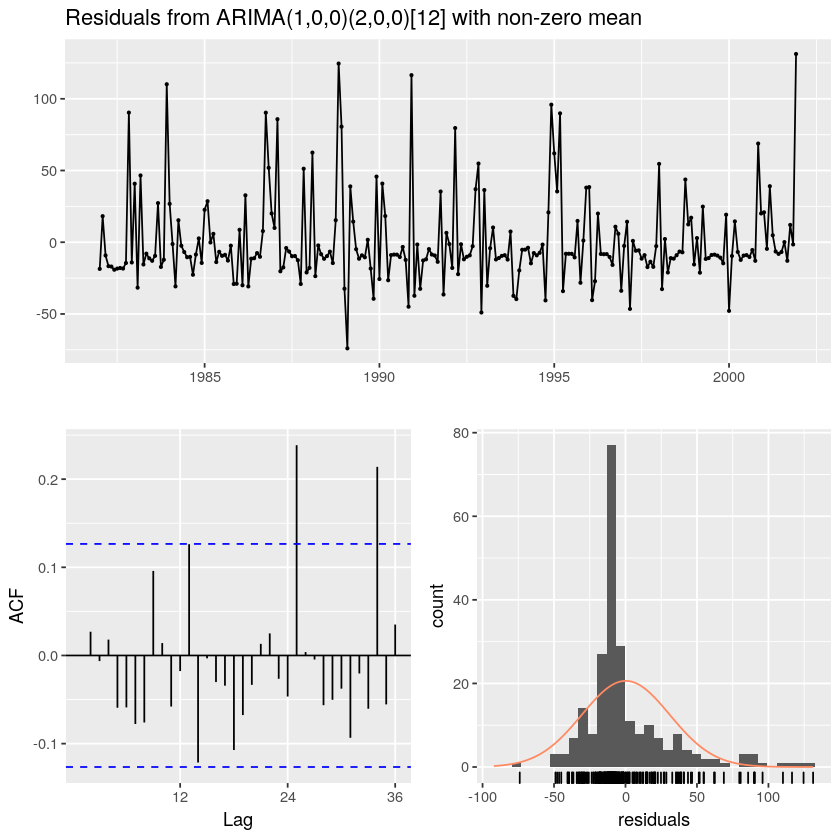

In [15]:
checkresiduals(A)

In [ ]:
YlOrBr <- c("#FFFFD4", "#FED98E", "#FE9929", "#D95F0E", "#993404")

ggmap(map) +
stat_density2d(data = df, aes(x=longitude, y=latitude, fill = ..level.., alpha = ..level..),
               geom = "polygon", size = 0.005, bins = 20) +
scale_fill_gradient(low = "red", high = "green") +
scale_alpha(range = c(0, 0.3), guide = FALSE)